Controle clássico para um Guindaste Hidráulico Florestal

In [1]:
# Operações com matrizes e vetores:
import numpy as np
import sympy as sp
import control as co_general
import control.matlab as co
import matplotlib.pyplot as plt


 - Declaração das FTs que serão usadas

In [2]:
# Simbolos utilizados:
s = co.tf('s')

In [3]:
# Função de transferência do sistema em malha aberta:
dem = s**6 + 0.02774*s**5 + 26.03*s**4 + 0.1328*s**3 + 30.03*s**2 - 0.1616*s - 120
num = -0.0002981*s**4 - 7.27e-07*s**3 - 0.001487*s**2 + 4.095e-07*s + 0.0009274
G = num/dem
 
print(G)


-0.0002981 s^4 - 7.27e-07 s^3 - 0.001487 s^2 + 4.095e-07 s + 0.0009274
-----------------------------------------------------------------------
s^6 + 0.02774 s^5 + 26.03 s^4 + 0.1328 s^3 + 30.03 s^2 - 0.1616 s - 120



- Identificando os polos do sistema em malha aberta

[-0.01181462+4.96099788j -0.01181462-4.96099788j -0.00154511+1.74020406j
 -0.00154511-1.74020406j -1.26938876+0.j          1.26836822+0.j        ]
[-0.00121991+2.35561333j -0.00121991-2.35561333j  0.74877063+0.j
 -0.74876958+0.j        ]


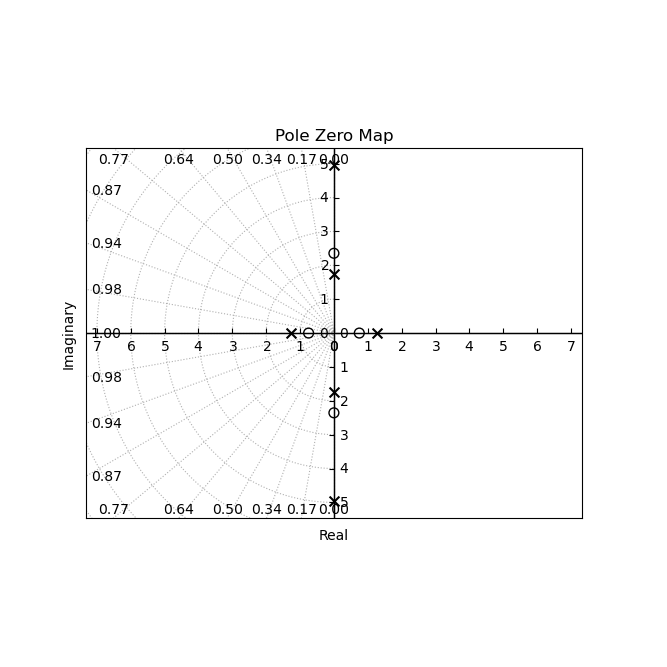

In [4]:
polos = co.pole(G)
zeros = co.zero(G)
co.pzmap(G, plot=True, grid=True, title='Pole Zero Map')


print(polos)
print(zeros)

- Calcula a estabilidade do sistema em malha aberta

In [5]:
# Verificando as condições de Routh-Hurwitz
# Script para verificar as condições de Routh-Hurwitz será disponibilizado em SCILAB
condicoes_estabilidade = np.all(np.real(polos) < 0)

if condicoes_estabilidade:
    print("O sistema é estável pelo critério de Routh-Hurwitz.")
else:
    print("O sistema é instável pelo critério de Routh-Hurwitz.")

O sistema é instável pelo critério de Routh-Hurwitz.


(array([7.83257035e-06, 7.83401714e-06, 7.83548395e-06, 7.83697105e-06,
        7.83847872e-06, 7.84000724e-06, 7.84155690e-06, 7.84312798e-06,
        7.84472079e-06, 7.84633562e-06, 7.84797277e-06, 7.84963256e-06,
        7.85131528e-06, 7.85302126e-06, 7.85475081e-06, 7.85650425e-06,
        7.85828192e-06, 7.86008415e-06, 7.86191127e-06, 7.86376362e-06,
        7.86564156e-06, 7.86754542e-06, 7.86947557e-06, 7.87143236e-06,
        7.87341616e-06, 7.87542734e-06, 7.87746627e-06, 7.87953333e-06,
        7.88162891e-06, 7.88375340e-06, 7.88590719e-06, 7.88809068e-06,
        7.89030428e-06, 7.89254840e-06, 7.89482346e-06, 7.89712987e-06,
        7.89946806e-06, 7.90183848e-06, 7.90424155e-06, 7.90667773e-06,
        7.90914746e-06, 7.91165120e-06, 7.91418942e-06, 7.91676258e-06,
        7.91937116e-06, 7.92201564e-06, 7.92469652e-06, 7.92741427e-06,
        7.93016942e-06, 7.93296245e-06, 7.93579390e-06, 7.93866428e-06,
        7.94157412e-06, 7.94452395e-06, 7.94751432e-06, 7.950545

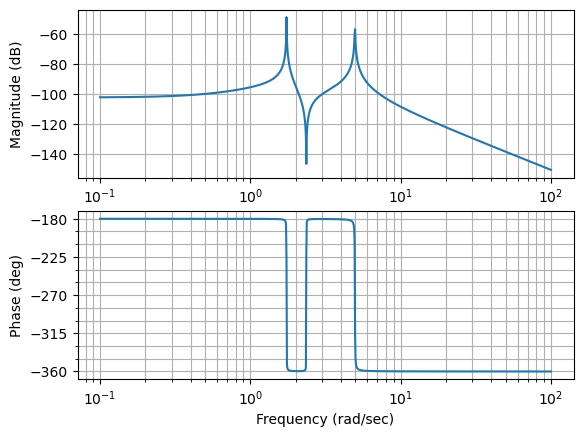

In [6]:
co.bode(G)

ValueError: array of sample points is empty

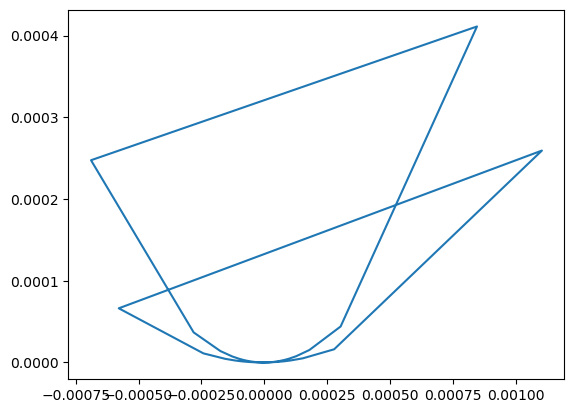

In [7]:
co.nyquist(G)

- Resposta do sistema em malha aberta a uma entrada degrau

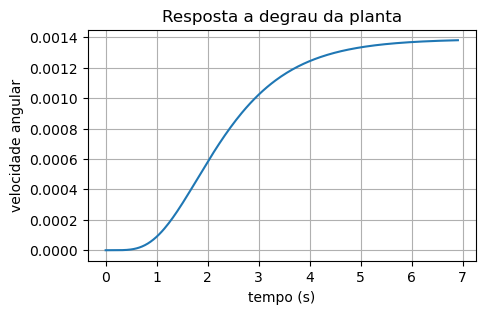

In [ ]:
# Resposta a degrau da planta
plt.figure(2, figsize=(5,3))
omegao, t = co.step(G)
plt.plot(t,omegao)
plt.title('Resposta a degrau da planta')
plt.xlabel('tempo (s)')
plt.ylabel('velocidade angular')
plt.grid()

Ziegler-Nichols'

In [ ]:
def pid_ziegler_nichols(g):
    _, y = co_general.step_response(g)
    
    k = y[-1]
    t = co_general.step_info(g)['RiseTime']
    
    kp = 0.6 * k
    ki = 1.2 / t
    kd = 0.075 * t
    
    return kp, ki, kd

In [ ]:
# Calcular os parâmetros do controlador PID usando Ziegler-Nichols
kp, ki, kd = pid_ziegler_nichols(G)

# Exibir os parâmetros do controlador PID
print("Parâmetros do Controlador PID:")
print("Kp =", kp)
print("Ki =", ki)
print("Kd =", kd)

Parâmetros do Controlador PID:
Kp = 0.000828345816679172
Ki = 0.4113506224819451
Kd = 0.21879145206337994


- Alocação de polos

In [ ]:
# Converter a função de transferência em espaço de estados
sys_ss = co_general.tf2ss(G)

# Definir os polos desejados
polos_desejados = [-2, -3]

# Realizar a alocação de polos
K = co_general.place(sys_ss.A, sys_ss.B, polos_desejados)

# Exibir a matriz de ganhos do controlador
print("Matriz de ganhos do controlador:")
print(K)


Matriz de ganhos do controlador:
[[3. 5.]]


- Controle Ótimo ITAE

In [ ]:
def itae_cost(x, G):
    Kp = x
    Ki = x
    Kd = x
    C = co_general.tf([Kd, Kp, Ki], [1, 0])
    L = co_general.series(C, G)
    T = co_general.feedback(L, 1)
    t, y = co_general.step_response(T)
    e = 1 - y
    cost = sum(t * abs(e))
    return cost

In [ ]:
from scipy.optimize import minimize_scalar


# Encontrar os ganhos ótimos que minimizam o custo ITAE
result = minimize_scalar(itae_cost, args=(G,), bounds=(0, 10), method='bounded')

# Obter o ganho ótimo
K_opt = result.x

# Criar o controlador PID ótimo
C = co_general.tf([0.6 * K_opt, 1.2 / K_opt, 0.075 * K_opt], [1, 0])

# Exibir os ganhos ótimos
print("Ganhos ótimos:")
print("Kp =", 0.6 * K_opt)
print("Ki =", 1.2 / K_opt)
print("Kd =", 0.075 * K_opt)

# Exibir a função de transferência do controlador ótimo
print("Função de transferência do controlador ótimo:")
print(co_general.minreal(C))


Ganhos ótimos:
Kp = 5.989152022009216
Ki = 0.12021735253239696
Kd = 0.748644002751152
Função de transferência do controlador ótimo:

5.989 s^2 + 0.1202 s + 0.7486
-----------------------------
              s

0 states have been removed from the model

5.989 s^2 + 0.1202 s + 0.7486
-----------------------------
              s

